## 中央値フィルタのボード線図

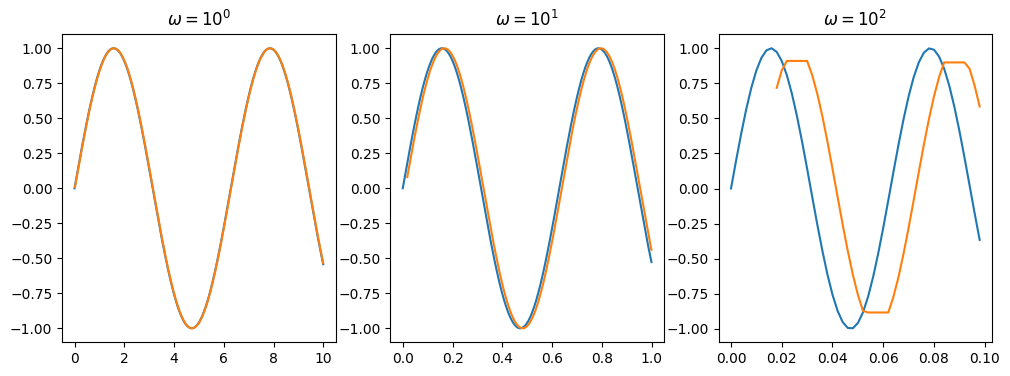

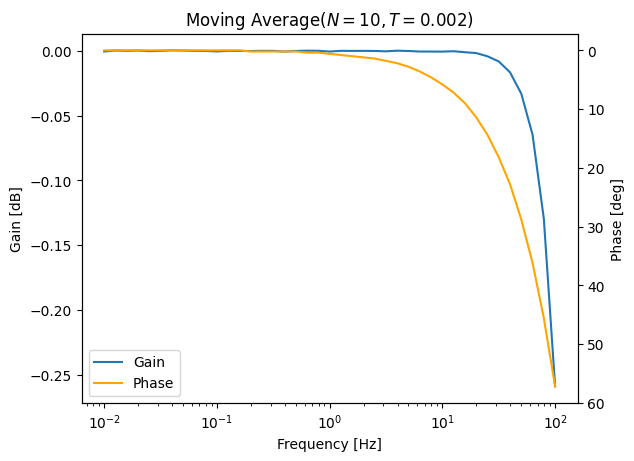

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, prange

# モデル設定
dt = 2e-3
N = 10

x_low = -2
x_high = 2
x_slice = 10
num = x_slice * (x_high - x_low) + 1
exp = np.logspace(x_low, x_high, num)

@jit(nopython=True, cache=True, fastmath=True, nogil=True)
def calc_med(f, N):
  y = np.empty_like(f)
  y[0:N] = np.nan
  for i in range(N-1, len(f)):
    y[i] = np.median(f[i-N+1:i])
  return y

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def calc_amp(f, y):
  return np.abs(y).mean() / np.abs(f).mean()

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def calc_phase_delay(t, y, omega):
  # 位相遅れを取得
  phases = np.arange(0, 90, 0.2)
  diff = np.empty_like(phases)
  for i in prange(len(phases)):
    deg = phases[i]
    rad = deg * np.pi / 180
    ref = np.sin(omega * t - rad)
    diff[i] = np.abs(y - ref).sum()
  return phases[np.argmin(diff)]

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def f(exp, N, dt):
  t = np.arange(0, 800, dt)
  half = len(t) // 4 * 3
  amp = np.empty_like(exp)
  theta = np.empty_like(exp)
  for j in prange(len(exp)):
    omega = exp[j]
    f = np.sin(omega * t)
    y = calc_med(f, N)
    amp[j] = calc_amp(f[half:], y[half:])
    theta[j] = calc_phase_delay(t[half:], y[half:], omega)
  gain = 20 * np.log10(amp)
  return [amp, gain, theta]

[amp, gain, theta] = f(exp, N, dt)

def example():
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  for i in range(3):
    t = np.arange(0, 10**(1-i), dt)
    fs = np.sin(t * 10**i)
    y = calc_med(fs, N)
    axes[i].set_title(rf"$\omega = 10^{{{i}}}$")
    axes[i].plot(t, fs, label="Input")
    axes[i].plot(t, y, label="Output")
  plt.show()
example()

plt.figure()
plt.title(rf"Moving Average($N={N},T={dt}$)")
plt.gca().set_xscale('log')
# plt.plot(exp, amp, label="amp")
plt.plot(exp, gain, label="Gain")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Gain [dB]")

ax = plt.gca()
ax2 = plt.gca().twinx()
ax2.plot(exp, theta, label="Phase", color="orange")
ax2.set_ylabel("Phase [deg]")
ax2.invert_yaxis()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc="lower left")

plt.show()